In [462]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [463]:
from abc import ABC, abstractmethod
# Variations of AIMD
class TCPReno():
    '''
    Alpha and Beta are 1 and 0.5 respectively
    '''
    def __init__(self, cwnd):
        self.alpha = 1
        self.beta = 0.5
        self.cwnd = cwnd
        self.RTT_tracker = [cwnd]
    
    def AI(self):
        self.cwnd += 1
        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.cwnd = math.floor(self.cwnd * 0.5)
        self.RTT_tracker.append(self.cwnd)


class GAIMD():
    '''
    Generaic AIMD -> Adjustable Alpha and Beta
    Linear
    '''
    def __init__(self, alpha, beta, cwnd):
        self.alpha = alpha
        self.beta = beta
        self.cwnd = cwnd
        self.RTT_tracker = [cwnd]
    
    def AI(self):
        self.cwnd = math.floor(self.cwnd + self.alpha)
        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.cwnd = math.floor(self.cwnd * self.beta)
        self.RTT_tracker.append(self.cwnd)

class NonLinearAIMD(ABC):
    '''
    Non-Linear TCP with different non-linear increment functions
    '''
    def __init__(self, alpha, beta, cwnd, ssthresh):
        self.alpha = alpha
        self.beta = beta
        self.cwnd = cwnd
        self.ssthresh = ssthresh
        self.RTT_tracker = [cwnd]
    
    @abstractmethod
    def update_AI(self):
        pass

    @abstractmethod
    def update_MD(self):
        '''
        For better control of adjustments to variables -> Mostly Beta variable
        '''
        pass

    def AI(self):
        if self.cwnd < self.ssthresh:
            self.update_AI()
        self.cwnd = math.floor(self.cwnd + self.alpha)
        

        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.update_MD()
        self.cwnd = math.floor(self.cwnd * self.beta)
        self.RTT_tracker.append(self.cwnd)

class ExponentialAIMD(NonLinearAIMD):
    def __init__(self, alpha, beta, cwnd, ssthresh, exponent):
        super().__init__(alpha, beta, cwnd, ssthresh)
        self.exponent = exponent
        self.original_alpha = alpha
        self.original_beta = beta
        
    def update_AI(self):
        self.alpha = self.original_alpha * math.pow(self.cwnd, self.exponent)
    
    def update_MD(self):
        # self.alpha = 1
        pass

class LogAIMD(NonLinearAIMD):        
    def __init__(self, alpha, beta, cwnd, ssthresh):
        super().__init__(alpha, beta, cwnd, ssthresh)
        self.original_alpha = alpha
        self.original_beta = beta
        
    def update_AI(self):
        self.alpha = self.original_alpha * math.log(self.cwnd+1)
    
    def update_MD(self):
        # self.alpha = self.original_alpha
        pass



In [464]:
class Network():
    def __init__(self, capacity, users):
        self.capacity = capacity
        self.users = users
        self.congestion_events = []
        self.total_packets = []
        self.convergence_RTT = None
        self.total_packets_sent = None
        self.congestion_freq = None
    
    def run_one_RTT(self):
        c_sum = 0
        for user in self.users:
            c_sum += user.cwnd
                
        if c_sum <= self.capacity:
            # print('Additive I')
            for user in self.users:
                user.AI()
        
        else:
            print(f'Multiplicative D at {len(self.users[0].RTT_tracker)-1}')
            # Print first 2 users CWND
            print(f"U1: {self.users[0].cwnd}, U2: {self.users[1].cwnd}")
            # # Check most recent cwnd and prev congested cwnd
            # if self.users[0].RTT_tracker[-1] != self.prev_congested_cwnd:
            #     # Update RTT
            #     self.convergence_RTT = len(self.users[0].RTT_tracker) - 1
            #     # Update prev congested cwnd
            #     self.prev_congested_cwnd = self.users[0].RTT_tracker[-1]
            self.congestion_events.append(len(self.users[0].RTT_tracker)-1)
            for user in self.users:
                user.MD()
    
    def find_convergence(self):
        # sum_ = self.get_total_packets()
        for i in range(len(self.congestion_events)-2):
            try:
                event1 = self.congestion_events[i]
                event2 = self.congestion_events[i+1]
                if self.users[0].RTT_tracker[event1] == self.users[0].RTT_tracker[event2] and self.users[1].RTT_tracker[event1] == self.users[1].RTT_tracker[event2]:
                    self.convergence_RTT = event1
                    self.congestion_freq = event2 - event1

                    return event1
            except:
                return None
        
        print("No convergence found")
        return None        
    
    def visualise(self, name=None, show_eigenvector=False):
        '''
        Only shows the first 2 users
        '''
        plt.plot(self.users[0].RTT_tracker, self.users[1].RTT_tracker)
        
        plt.plot([0, self.capacity], [self.capacity, 0], 'k-', label='Efficiency')
        
        if show_eigenvector:
            x, y = self.calculate_eigenvector()
            # plt.plot([0, eigenvector[0] * self.capacity], [0, eigenvector[1] * self.capacity], 'r', linestyle='dashed', label='Eigenvector Line')
            plt.plot(x, y, 'r', linestyle='dashed', label='Eigenvector (fairness)')

        # Equal fariness
        plt.plot([0, self.capacity], [0, self.capacity], 'g', linestyle='dashed', label='Equal Fairness')
        plt.xlabel("User 1")
        plt.ylabel("User 2")
        plt.title(f"{name}")
        plt.legend()
        plt.show()
    
    def visualiseRTT(self, name=None):
        # sum_ = np.zeros(len(self.users[0].RTT_tracker))
        x = [i for i in range(len(self.users[0].RTT_tracker))]
        for i, u in enumerate(self.users):
            plt.plot(x, u.RTT_tracker, label=f"User {i+1}")
            # sum_ += np.array(u.RTT_tracker)

        plt.plot(x, self.get_total_packets(), label="Total CWND")

        plt.xlabel("RTT")
        plt.ylabel("CWND")
        plt.title(f"{name}")
        plt.axhline(y=self.capacity, color='black', linestyle='--', label='Capacity')
        plt.legend()
        plt.show()
    
    def calculate_eigenvector(self):
        ''' 
        Generates a series of points for the expected distribution of network based on the first 2 users
        '''
        thresh = 50
        eigenvector = []
        for i in range(2):
            u = self.users[i]
            eigenvector.append(u.alpha/(1-u.beta))
        
        # # Normalise
        # eigenvector = np.array(eigenvector)
        # eigenvector = eigenvector / sum(eigenvector)
        
        grad = eigenvector[1]/eigenvector[0]
        x = np.linspace(0, self.capacity, 100)
        y = grad * x

        # Remove any Y > capacity
        mask = y <= self.capacity + thresh
        
        # return x, y
        return x[mask], y[mask]
    
    def get_total_packets(self):
        sum_ = np.zeros(len(self.users[0].RTT_tracker))
        for i, u in enumerate(self.users):
            sum_ += np.array(u.RTT_tracker)
        
        return sum_

    def calculate_throughput(self):
        '''
        Calculate throughput of network
        '''
        sum_ = self.get_total_packets()
        mask = sum_ <= self.capacity
        
        self.total_packets_sent = sum_[mask].sum()


    def run(self, iterations, name, show_eigenvector=False):
        for i in range(1, iterations):
            self.run_one_RTT()

        self.find_convergence()
        self.calculate_throughput()

        print(f"Convergence RTT: {self.convergence_RTT}; Frequency: {self.congestion_freq}")
        print(f"Total packets sent: {self.total_packets_sent}; Average sent/RTT: {self.total_packets_sent/iterations}")

        # print(f"Convergence RTT: {self.convergence_RTT}")
        self.visualise(name, show_eigenvector)
        self.visualiseRTT(name)


In [465]:
a = np.array([1, 1])
a = a / sum(a)
a[0]

0.5

In [466]:
def run_simulation(ITERATESMAX, C, users, name, show_eigenvector=False):
    print("*"*20 +f" {name} " + "*"*20)

    # Display the initial values
    for i, u in enumerate(users):
        print(f"Initial User-{i+1} CWND:", u.RTT_tracker[0])

    # Simulate the network
    network = Network(C, users)
    network.run(ITERATESMAX, name, show_eigenvector)

******************** Standard AIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 45
U1: 47, U2: 55
Multiplicative D at 72
U1: 49, U2: 53
Multiplicative D at 99
U1: 50, U2: 52
Multiplicative D at 125
U1: 50, U2: 51
Multiplicative D at 152
U1: 51, U2: 51
Multiplicative D at 179
U1: 51, U2: 51
Multiplicative D at 206
U1: 51, U2: 51
Multiplicative D at 233
U1: 51, U2: 51
Multiplicative D at 260
U1: 51, U2: 51
Multiplicative D at 287
U1: 51, U2: 51
Convergence RTT: 152; Frequency: 27
Total packets sent: 20727.0; Average sent/RTT: 69.09


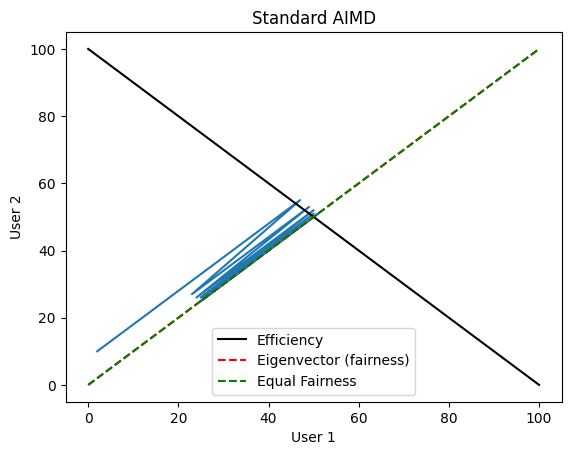

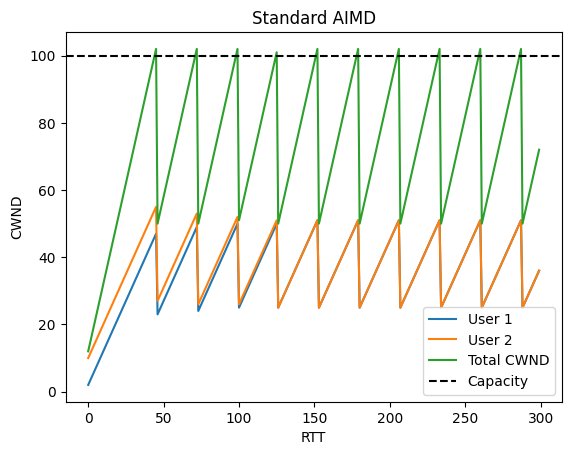

In [467]:
# Standard
ITERATESMAX = 300 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Users
ALPHA = 1
BETA = 0.5

# TCP Reno Users
num_users = 2
users = [TCPReno(2), TCPReno(10)]
name = "Standard AIMD"

run_simulation(ITERATESMAX, C, users, name, True)


Slow convergence however quite stable (MD every 27 RTTs)

******************** Aggressive  GAIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 5
U1: 52, U2: 60
Multiplicative D at 7
U1: 51, U2: 58
Multiplicative D at 9
U1: 50, U2: 56
Multiplicative D at 11
U1: 50, U2: 54
Multiplicative D at 13
U1: 50, U2: 53
Multiplicative D at 15
U1: 50, U2: 52
Multiplicative D at 17
U1: 50, U2: 51
Multiplicative D at 20
U1: 60, U2: 60
Multiplicative D at 22
U1: 58, U2: 58
Multiplicative D at 24
U1: 56, U2: 56
Multiplicative D at 26
U1: 54, U2: 54
Multiplicative D at 28
U1: 53, U2: 53
Multiplicative D at 30
U1: 52, U2: 52
Multiplicative D at 32
U1: 51, U2: 51
Multiplicative D at 35
U1: 60, U2: 60
Multiplicative D at 37
U1: 58, U2: 58
Multiplicative D at 39
U1: 56, U2: 56
Multiplicative D at 41
U1: 54, U2: 54
Multiplicative D at 43
U1: 53, U2: 53
Multiplicative D at 45
U1: 52, U2: 52
Multiplicative D at 47
U1: 51, U2: 51
Multiplicative D at 50
U1: 60, U2: 60
Multiplicative D at 52
U1: 58, U2: 58
Multiplicative D at 54

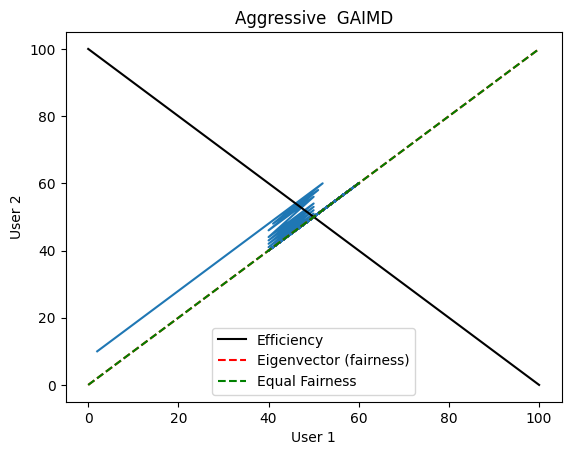

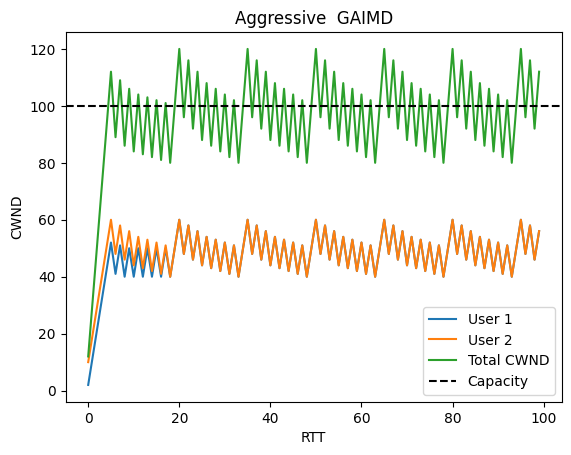

In [468]:
# Aggressive GAIMD
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [0.1*C, 0.1*C]

betas = [0.8, 0.8]

init_cwnds = [2, 10]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Aggressive  GAIMD"

run_simulation(ITERATESMAX, C, users, name, True)

No convergence, frequent congestion

******************** Friendly  GAIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 45
U1: 47, U2: 55
Multiplicative D at 87
U1: 50, U2: 52
Multiplicative D at 129
U1: 51, U2: 51
Multiplicative D at 171
U1: 51, U2: 51
Multiplicative D at 213
U1: 51, U2: 51
Multiplicative D at 255
U1: 51, U2: 51
Multiplicative D at 297
U1: 51, U2: 51
Convergence RTT: 129; Frequency: 42
Total packets sent: 17322.0; Average sent/RTT: 57.74


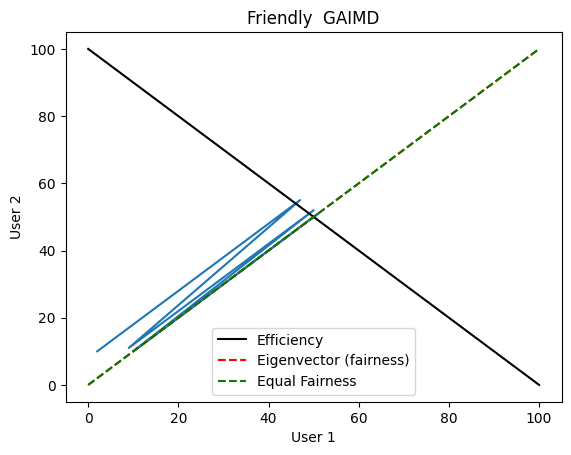

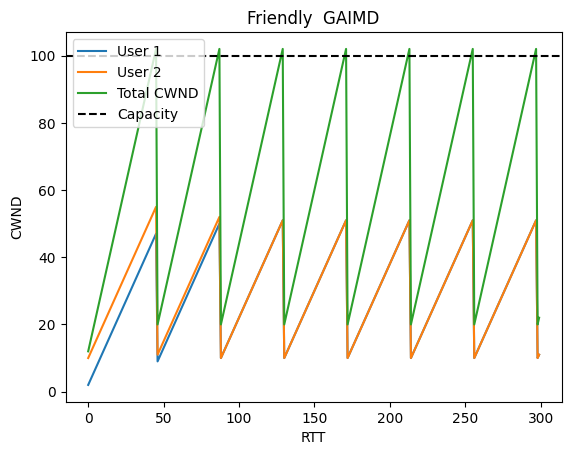

In [469]:
# Friendly GAIMD
ITERATESMAX = 300 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.2, 0.2]

init_cwnds = [2, 10]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Friendly  GAIMD"
run_simulation(ITERATESMAX, C, users, name, True)

******************** Mixed  GAIMD - Alpha = [1, 10.0]; Beta = [0.2, 0.8] ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 9
U1: 11, U2: 100
Multiplicative D at 12
U1: 4, U2: 100
Multiplicative D at 15
U1: 2, U2: 100
Multiplicative D at 18
U1: 2, U2: 100
Multiplicative D at 21
U1: 2, U2: 100
Multiplicative D at 24
U1: 2, U2: 100
Multiplicative D at 27
U1: 2, U2: 100
Multiplicative D at 30
U1: 2, U2: 100
Multiplicative D at 33
U1: 2, U2: 100
Multiplicative D at 36
U1: 2, U2: 100
Multiplicative D at 39
U1: 2, U2: 100
Multiplicative D at 42
U1: 2, U2: 100
Multiplicative D at 45
U1: 2, U2: 100
Multiplicative D at 48
U1: 2, U2: 100
Multiplicative D at 51
U1: 2, U2: 100
Multiplicative D at 54
U1: 2, U2: 100
Multiplicative D at 57
U1: 2, U2: 100
Multiplicative D at 60
U1: 2, U2: 100
Multiplicative D at 63
U1: 2, U2: 100
Multiplicative D at 66
U1: 2, U2: 100
Multiplicative D at 69
U1: 2, U2: 100
Multiplicative D at 72
U1: 2, U2: 100
Multiplicative D at 75


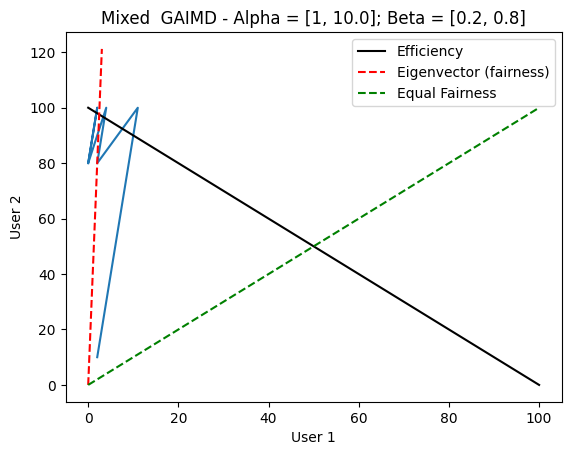

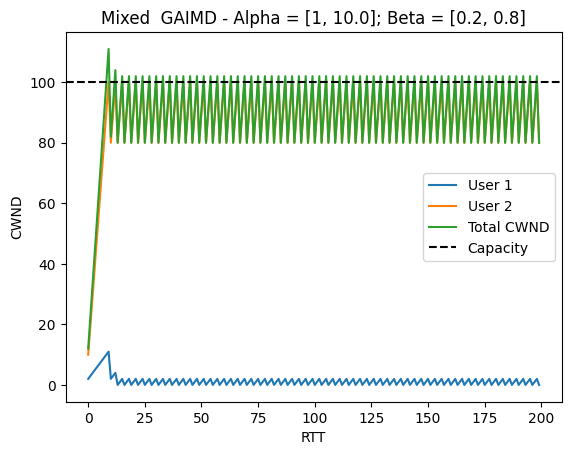

In [470]:
# Mixed GAIMD
# User 2 is more agreesive
ITERATESMAX = 200 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [1, 0.1*C]

betas = [0.2, 0.8]

init_cwnds = [2, 10]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = f"Mixed  GAIMD - Alpha = {alphas}; Beta = {betas}"

run_simulation(ITERATESMAX, C, users, name, True)

# print(users[0].RTT_tracker)

******************** Mixed  GAIMD V2 - Alpha = [1, 10.0]; Beta = [0.8, 0.2] ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 9
U1: 11, U2: 100
Multiplicative D at 17
U1: 15, U2: 90
Multiplicative D at 25
U1: 19, U2: 88
Multiplicative D at 33
U1: 22, U2: 87
Multiplicative D at 41
U1: 24, U2: 87
Multiplicative D at 48
U1: 25, U2: 77
Multiplicative D at 55
U1: 26, U2: 75
Multiplicative D at 62
U1: 26, U2: 75
Multiplicative D at 69
U1: 26, U2: 75
Multiplicative D at 76
U1: 26, U2: 75
Multiplicative D at 83
U1: 26, U2: 75
Multiplicative D at 90
U1: 26, U2: 75
Multiplicative D at 97
U1: 26, U2: 75
Convergence RTT: 55; Frequency: 7
Total packets sent: 5383.0; Average sent/RTT: 53.83


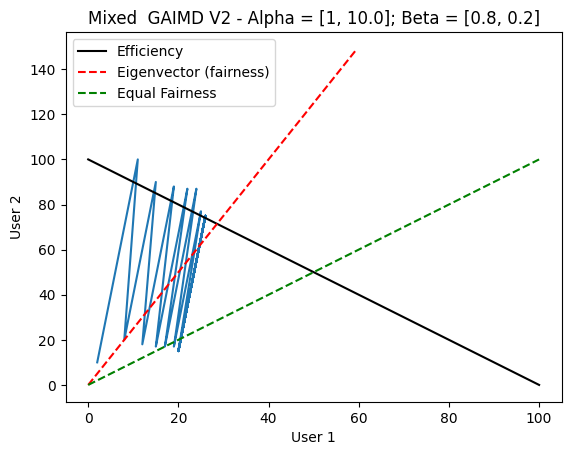

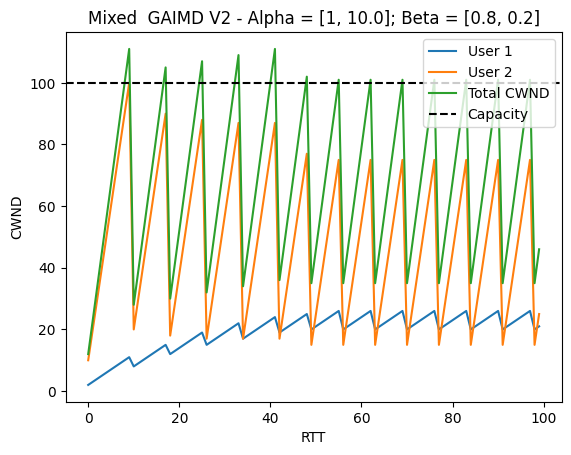

24 55


In [471]:
# Mixed GAIMD v2
# User 2 is more agreesive
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [1, 0.1*C]

betas = [0.8, 0.2]

init_cwnds = [2, 10]
# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = f"Mixed  GAIMD V2 - Alpha = {alphas}; Beta = {betas}"

run_simulation(ITERATESMAX, C, users, name, True)
print(users[0].RTT_tracker[95], users[1].RTT_tracker[95])

Overall, a more agressive AIMD results in faster convergence but also more frequent congestion. On the other hand, a more friendly approach results in a longer time taken to converge, but there are fewer congestion events.

******************** Many users Aggressive GAIMD ********************
Initial User-1 CWND: 5
Initial User-2 CWND: 11
Initial User-3 CWND: 12
Initial User-4 CWND: 8
Initial User-5 CWND: 9
Initial User-6 CWND: 11
Initial User-7 CWND: 5
Initial User-8 CWND: 15
Initial User-9 CWND: 0
Initial User-10 CWND: 16
Initial User-11 CWND: 1
Initial User-12 CWND: 12
Initial User-13 CWND: 7
Initial User-14 CWND: 13
Initial User-15 CWND: 28
Initial User-16 CWND: 6
Initial User-17 CWND: 25
Initial User-18 CWND: 18
Initial User-19 CWND: 20
Initial User-20 CWND: 5
Multiplicative D at 0
U1: 5, U2: 11
Multiplicative D at 1
U1: 4, U2: 8
Multiplicative D at 2
U1: 3, U2: 6
Multiplicative D at 4
U1: 12, U2: 14
Multiplicative D at 5
U1: 9, U2: 11
Multiplicative D at 6
U1: 7, U2: 8
Multiplicative D at 7
U1: 5, U2: 6
Multiplicative D at 9
U1: 14, U2: 14
Multiplicative D at 10
U1: 11, U2: 11
Multiplicative D at 11
U1: 8, U2: 8
Multiplicative D at 12
U1: 6, U2: 6
Multiplicative D at 14
U1: 14, U2: 14
Multiplicative

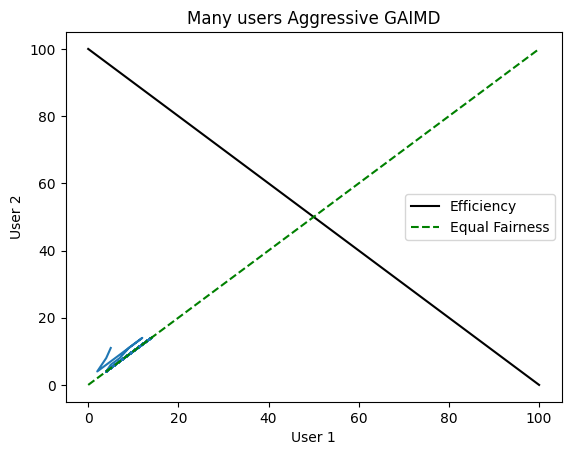

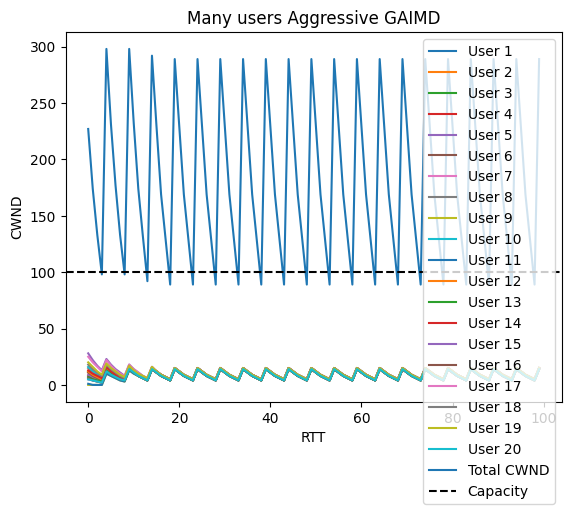

In [472]:
# Many Aggressive GAIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

num_users = 20

alphas = [0.1*C] * num_users

betas = [0.8] * num_users

init_cwnds = [np.random.randint(30) for i in range(num_users)]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
# num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Many users Aggressive GAIMD"

run_simulation(ITERATESMAX, C, users, name)

An issue with the above is that it carries out MD phase of AIMD almost every RTT due to the many aggressive users. This is exacerbated by the high beta value, resulting in the users not losing much CWND, resulting in the network still being congested. Thus, it takes a while before finally reaching a suitable CWND amount to be shared among all users. However, once that valid CWND occurs, it then quickly rises up again. This may result in a low throughput as the network does not have the bandwidth for all these users.

******************** Many friendly GAIMD ********************
Initial User-1 CWND: 5
Initial User-2 CWND: 11
Initial User-3 CWND: 12
Initial User-4 CWND: 8
Initial User-5 CWND: 9
Initial User-6 CWND: 11
Initial User-7 CWND: 5
Initial User-8 CWND: 15
Initial User-9 CWND: 0
Initial User-10 CWND: 16
Initial User-11 CWND: 1
Initial User-12 CWND: 12
Initial User-13 CWND: 7
Initial User-14 CWND: 13
Initial User-15 CWND: 28
Initial User-16 CWND: 6
Initial User-17 CWND: 25
Initial User-18 CWND: 18
Initial User-19 CWND: 20
Initial User-20 CWND: 5
Multiplicative D at 0
U1: 5, U2: 11
Multiplicative D at 6
U1: 5, U2: 6
Multiplicative D at 13
U1: 6, U2: 6
Multiplicative D at 20
U1: 6, U2: 6
Multiplicative D at 27
U1: 6, U2: 6
Multiplicative D at 34
U1: 6, U2: 6
Multiplicative D at 41
U1: 6, U2: 6
Multiplicative D at 48
U1: 6, U2: 6
Multiplicative D at 55
U1: 6, U2: 6
Multiplicative D at 62
U1: 6, U2: 6
Multiplicative D at 69
U1: 6, U2: 6
Multiplicative D at 76
U1: 6, U2: 6
Multiplicative D at 83
U1

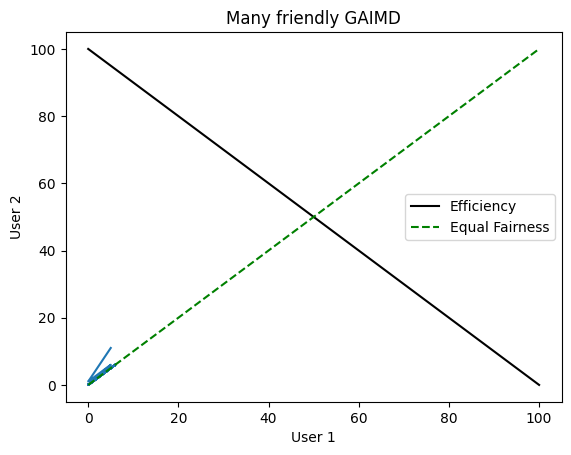

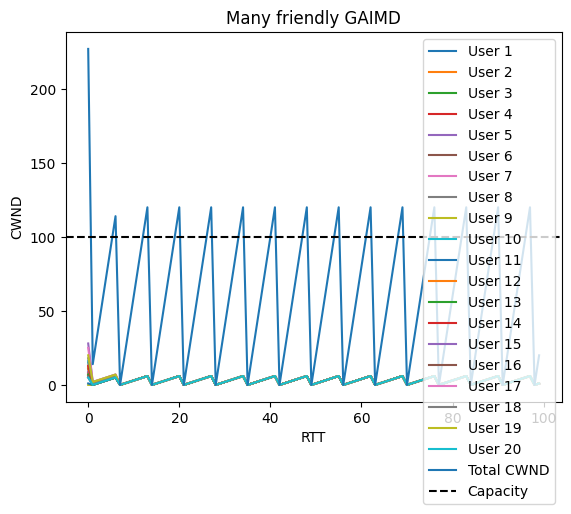

In [473]:
# Many friendly GAIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

num_users = 20

alphas = [1] * num_users

betas = [0.1] * num_users

init_cwnds = [np.random.randint(30) for i in range(num_users)]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
# num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Many friendly GAIMD"

run_simulation(ITERATESMAX, C, users, name)

Congestion occurs every 7 RTT which is much lower than the many agressive users scenario. This may be a more suitable setting for a network of relatively low capacity with many users.

******************** Low Alpha, High beta GAIMD ********************
Initial User-1 CWND: 5
Initial User-2 CWND: 11
Initial User-3 CWND: 12
Initial User-4 CWND: 8
Initial User-5 CWND: 9
Initial User-6 CWND: 11
Initial User-7 CWND: 5
Initial User-8 CWND: 15
Initial User-9 CWND: 0
Initial User-10 CWND: 16
Initial User-11 CWND: 1
Initial User-12 CWND: 12
Initial User-13 CWND: 7
Initial User-14 CWND: 13
Initial User-15 CWND: 28
Initial User-16 CWND: 6
Initial User-17 CWND: 25
Initial User-18 CWND: 18
Initial User-19 CWND: 20
Initial User-20 CWND: 5
Multiplicative D at 0
U1: 5, U2: 11
Multiplicative D at 1
U1: 4, U2: 8
Multiplicative D at 2
U1: 3, U2: 6
Multiplicative D at 4
U1: 3, U2: 5
Multiplicative D at 6
U1: 3, U2: 5
Multiplicative D at 9
U1: 4, U2: 6
Multiplicative D at 11
U1: 4, U2: 5
Multiplicative D at 14
U1: 5, U2: 6
Multiplicative D at 16
U1: 5, U2: 5
Multiplicative D at 18
U1: 5, U2: 5
Multiplicative D at 21
U1: 6, U2: 6
Multiplicative D at 24
U1: 6, U2: 6
Multiplicative D at 26

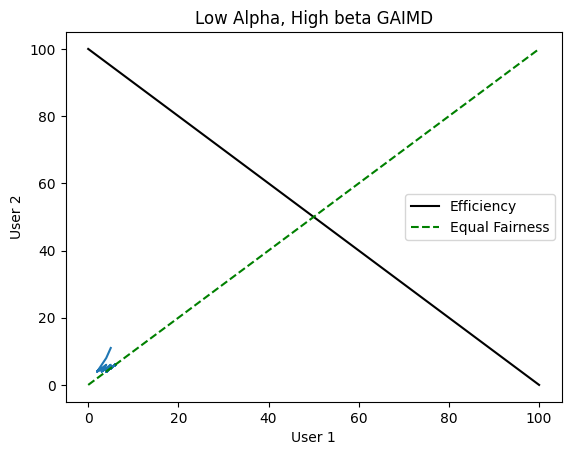

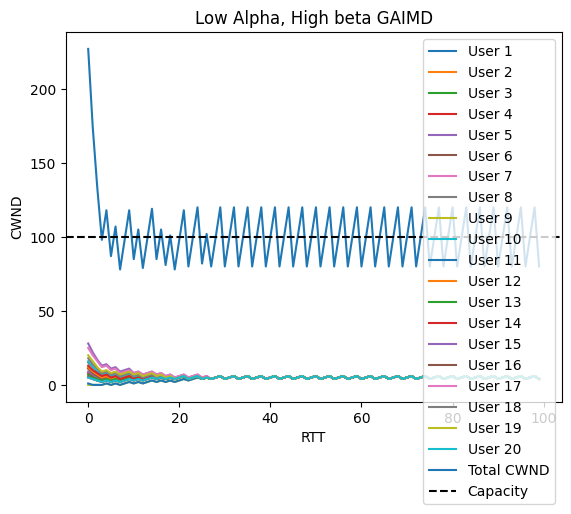

In [474]:
# Low Alpha, High beta GAIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

num_users = 20

alphas = [1] * num_users

betas = [0.8] * num_users

init_cwnds = [np.random.randint(30) for i in range(num_users)]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
# num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Low Alpha, High beta GAIMD"

run_simulation(ITERATESMAX, C, users, name)

By using a more passive AI phase, and a higher beta value, this ensures that the bandwidth for the users reached are valid and can be accounted for.

******************** High Alpha, low beta GAIMD ********************
Initial User-1 CWND: 5
Initial User-2 CWND: 11
Initial User-3 CWND: 12
Initial User-4 CWND: 8
Initial User-5 CWND: 9
Initial User-6 CWND: 11
Initial User-7 CWND: 5
Initial User-8 CWND: 15
Initial User-9 CWND: 0
Initial User-10 CWND: 16
Initial User-11 CWND: 1
Initial User-12 CWND: 12
Initial User-13 CWND: 7
Initial User-14 CWND: 13
Initial User-15 CWND: 28
Initial User-16 CWND: 6
Initial User-17 CWND: 25
Initial User-18 CWND: 18
Initial User-19 CWND: 20
Initial User-20 CWND: 5
Multiplicative D at 0
U1: 5, U2: 11
Multiplicative D at 2
U1: 10, U2: 11
Multiplicative D at 4
U1: 11, U2: 11
Multiplicative D at 6
U1: 11, U2: 11
Multiplicative D at 8
U1: 11, U2: 11
Multiplicative D at 10
U1: 11, U2: 11
Multiplicative D at 12
U1: 11, U2: 11
Multiplicative D at 14
U1: 11, U2: 11
Multiplicative D at 16
U1: 11, U2: 11
Multiplicative D at 18
U1: 11, U2: 11
Multiplicative D at 20
U1: 11, U2: 11
Multiplicative D at 22
U1: 11, U2: 11

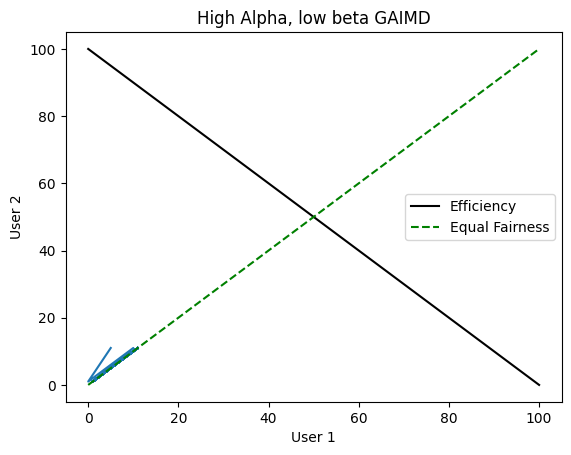

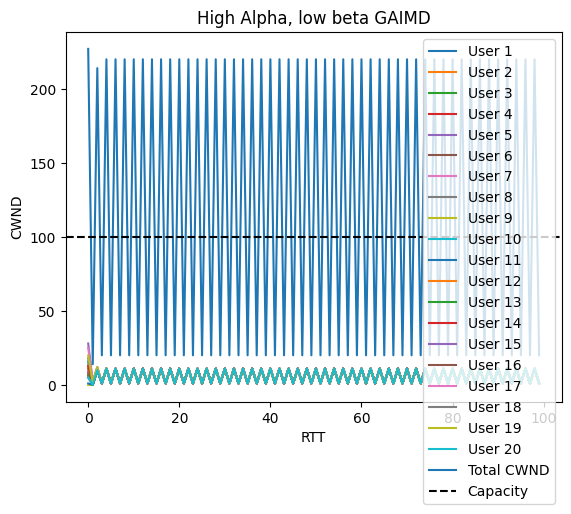

In [475]:
# High Alpha, low beta GAIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

num_users = 20

alphas = [10] * num_users

betas = [0.1] * num_users

init_cwnds = [np.random.randint(30) for i in range(num_users)]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
# num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "High Alpha, low beta GAIMD"

run_simulation(ITERATESMAX, C, users, name)

Every 2 RTTs after convergence, there is congestion

Considerations: <br>
The alpha and beta value should take into account the max capacity of the network. A high alpha value among users with a relatively low capacity results in constant congestion. This can be slightly mitigated by having a low beta value that helps to reduce the CWND of users. However, with the high alpha value, congestion will occur again quickly.

******************** Exponential AIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 10
U1: 46, U2: 67
Multiplicative D at 15
U1: 46, U2: 59
Multiplicative D at 21
U1: 53, U2: 61
Multiplicative D at 26
U1: 50, U2: 55
Multiplicative D at 32
U1: 55, U2: 59
Multiplicative D at 37
U1: 52, U2: 54
Multiplicative D at 42
U1: 50, U2: 52
Multiplicative D at 48
U1: 55, U2: 57
Multiplicative D at 53
U1: 52, U2: 53
Multiplicative D at 59
U1: 57, U2: 57
Multiplicative D at 64
U1: 53, U2: 53
Multiplicative D at 70
U1: 57, U2: 57
Multiplicative D at 75
U1: 53, U2: 53
Multiplicative D at 81
U1: 57, U2: 57
Multiplicative D at 86
U1: 53, U2: 53
Multiplicative D at 92
U1: 57, U2: 57
Multiplicative D at 97
U1: 53, U2: 53
No convergence found
Convergence RTT: None; Frequency: None
Total packets sent: 5878.0; Average sent/RTT: 58.78


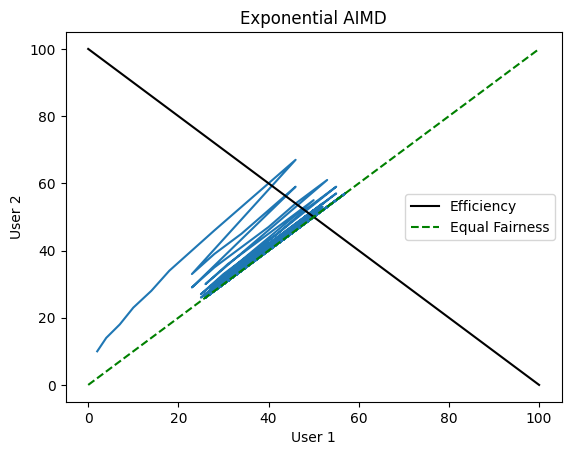

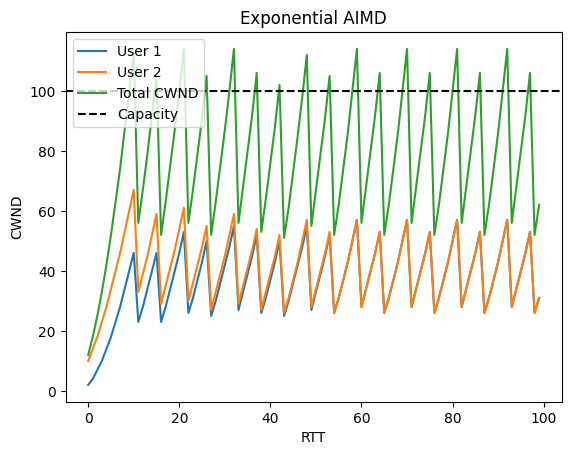

In [476]:
# Exponential
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [2, 2]

betas = [0.5, 0.5]

init_cwnds = [2, 10]

ssthresholds = [float('inf'), float('inf')]

exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(ExponentialAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i], exponents[i]))

name = "Exponential AIMD"
run_simulation(ITERATESMAX, C, users, name)

U1 and U2 do not attain the same value when starting at different CWND despite having the same parameters.

******************** Mixed Exponential AIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 10
U1: 46, U2: 495
Multiplicative D at 14
U1: 40, U2: 530
Multiplicative D at 18
U1: 36, U2: 561
Multiplicative D at 22
U1: 34, U2: 587
Multiplicative D at 25
U1: 27, U2: 486
Multiplicative D at 29
U1: 27, U2: 523
Multiplicative D at 33
U1: 27, U2: 554
Multiplicative D at 37
U1: 27, U2: 581
Multiplicative D at 40
U1: 22, U2: 481
Multiplicative D at 44
U1: 24, U2: 519
Multiplicative D at 48
U1: 26, U2: 552
Multiplicative D at 52
U1: 27, U2: 580
Multiplicative D at 55
U1: 22, U2: 481
Multiplicative D at 59
U1: 24, U2: 519
Multiplicative D at 63
U1: 26, U2: 552
Multiplicative D at 67
U1: 27, U2: 580
Multiplicative D at 70
U1: 22, U2: 481
Multiplicative D at 74
U1: 24, U2: 519
Multiplicative D at 78
U1: 26, U2: 552
Multiplicative D at 82
U1: 27, U2: 580
Multiplicative D at 85
U1: 22, U2: 481
Multiplicative D at 89
U1: 24, U2: 519
Multiplicative D at 93
U1: 26,

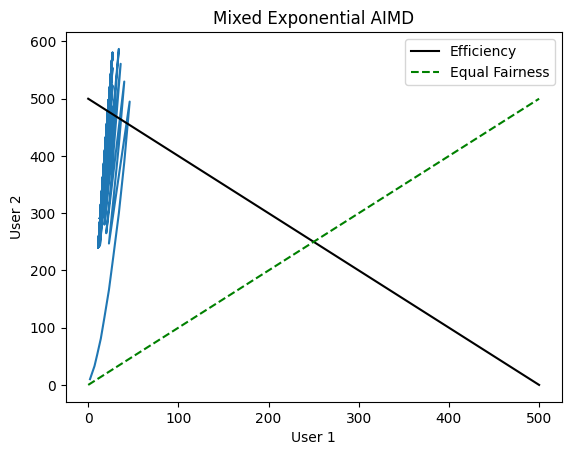

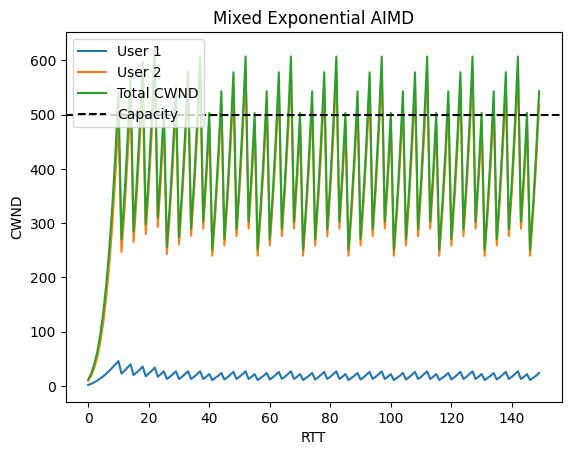

In [477]:
# Mixed Exponential
ITERATESMAX = 150 # You can adjust this value as needed
# Max Capacity of the network
C = 500

# params
ALPHA = 1
BETA = 0.5

alphas = [2, 2]

betas = [0.5, 0.5]

init_cwnds = [2, 10]

ssthresholds = [float('inf'), float('inf')]

exponents = [1/3, 2/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(ExponentialAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i], exponents[i]))

name = "Mixed Exponential AIMD"
run_simulation(ITERATESMAX, C, users, name)

******************** Many users Exponential AIMD ********************
Initial User-1 CWND: 6
Initial User-2 CWND: 12
Initial User-3 CWND: 13
Initial User-4 CWND: 9
Initial User-5 CWND: 10
Initial User-6 CWND: 12
Initial User-7 CWND: 6
Initial User-8 CWND: 16
Initial User-9 CWND: 1
Initial User-10 CWND: 17
Multiplicative D at 8
U1: 45, U2: 57
Multiplicative D at 13
U1: 45, U2: 53
Multiplicative D at 19
U1: 52, U2: 57
Multiplicative D at 24
U1: 50, U2: 53
Multiplicative D at 30
U1: 55, U2: 57
Multiplicative D at 35
U1: 52, U2: 53
Multiplicative D at 40
U1: 50, U2: 50
Multiplicative D at 46
U1: 55, U2: 55
Multiplicative D at 51
U1: 52, U2: 52
Multiplicative D at 57
U1: 57, U2: 57
Multiplicative D at 62
U1: 53, U2: 53
Multiplicative D at 68
U1: 57, U2: 57
Multiplicative D at 73
U1: 53, U2: 53
Multiplicative D at 79
U1: 57, U2: 57
Multiplicative D at 84
U1: 53, U2: 53
Multiplicative D at 90
U1: 57, U2: 57
Multiplicative D at 95
U1: 53, U2: 53
No convergence found
Convergence RTT: None; Freq

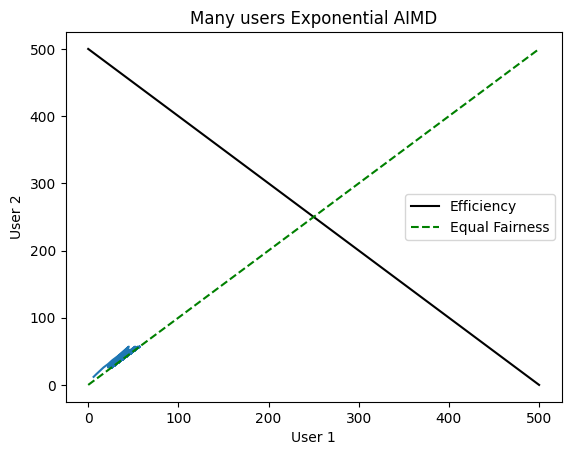

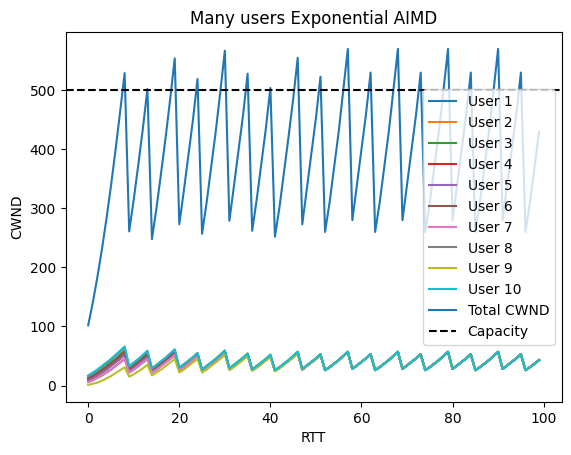

In [478]:
# Many users Mixed Exponential AIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 500

# params
ALPHA = 1
BETA = 0.5

# Users
num_users = 10
users = []

alphas = [2] * num_users

betas = [0.5] * num_users

init_cwnds = [np.random.randint(1, 30) for i in range(num_users)]

ssthresholds = [float('inf')] * num_users

exponents = [1/3] * num_users


for i in range(num_users):
    users.append(ExponentialAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i], exponents[i]))

name = "Many users Exponential AIMD"
run_simulation(ITERATESMAX, C, users, name)

Very dependent on who starts with the greater initial CWND. Those at the lower end are shown to greatly lose priority in the network and tend to result in having no share.

******************** Log AIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 19
U1: 42, U2: 64
Multiplicative D at 28
U1: 45, U2: 56
Multiplicative D at 38
U1: 49, U2: 55
Multiplicative D at 48
U1: 51, U2: 54
Multiplicative D at 58
U1: 52, U2: 54
Multiplicative D at 67
U1: 50, U2: 51
Multiplicative D at 77
U1: 52, U2: 52
Multiplicative D at 87
U1: 53, U2: 53
Multiplicative D at 97
U1: 53, U2: 53
Multiplicative D at 107
U1: 53, U2: 53
Multiplicative D at 117
U1: 53, U2: 53
Multiplicative D at 127
U1: 53, U2: 53
Multiplicative D at 137
U1: 53, U2: 53
Multiplicative D at 147
U1: 53, U2: 53
Multiplicative D at 157
U1: 53, U2: 53
Multiplicative D at 167
U1: 53, U2: 53
Multiplicative D at 177
U1: 53, U2: 53
Multiplicative D at 187
U1: 53, U2: 53
Multiplicative D at 197
U1: 53, U2: 53
Convergence RTT: 87; Frequency: 10
Total packets sent: 13138.0; Average sent/RTT: 65.69


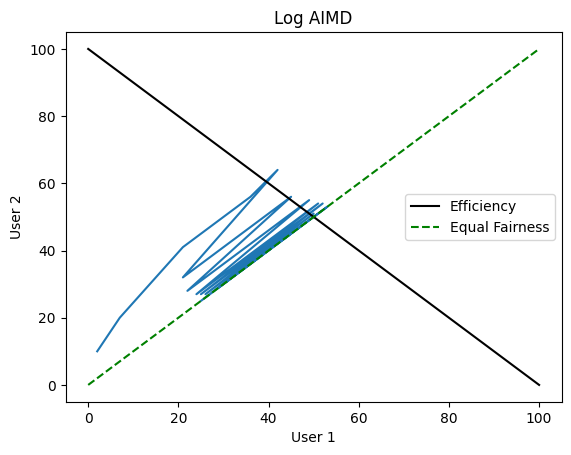

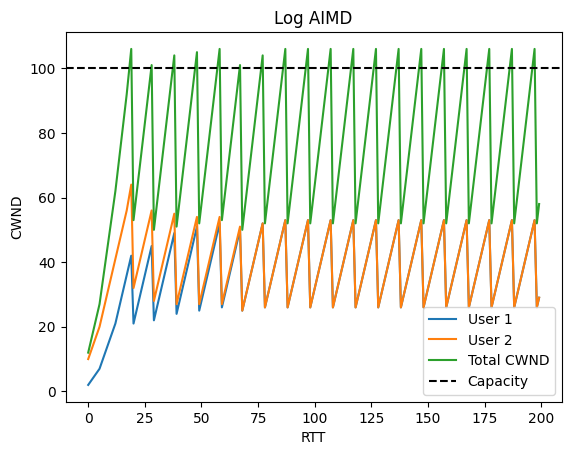

In [483]:
# Log
ITERATESMAX = 200 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.5, 0.5]

init_cwnds = [2, 10]

ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(LogAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i]))

name = "Log AIMD"
run_simulation(ITERATESMAX, C, users, name)

Behaves similarly to normal AIMD;however, it converges much faster (around 56 RTT compared to 142 for standard AIMD). MD every 3-4 RTTs

******************** Log AIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 2
U1: 37, U2: 68
Multiplicative D at 4
U1: 47, U2: 69
Multiplicative D at 6
U1: 54, U2: 69
Multiplicative D at 8
U1: 60, U2: 69
Multiplicative D at 10
U1: 64, U2: 69
Multiplicative D at 12
U1: 66, U2: 69
Multiplicative D at 14
U1: 68, U2: 69
Multiplicative D at 16
U1: 69, U2: 69
Multiplicative D at 18
U1: 69, U2: 69
Multiplicative D at 20
U1: 69, U2: 69
Multiplicative D at 22
U1: 69, U2: 69
Multiplicative D at 24
U1: 69, U2: 69
Multiplicative D at 26
U1: 69, U2: 69
Multiplicative D at 28
U1: 69, U2: 69
Multiplicative D at 30
U1: 69, U2: 69
Multiplicative D at 32
U1: 69, U2: 69
Multiplicative D at 34
U1: 69, U2: 69
Multiplicative D at 36
U1: 69, U2: 69
Multiplicative D at 38
U1: 69, U2: 69
Multiplicative D at 40
U1: 69, U2: 69
Multiplicative D at 42
U1: 69, U2: 69
Multiplicative D at 44
U1: 69, U2: 69
Multiplicative D at 46
U1: 69, U2: 69
Multiplicative D at 48
U1: 69, U

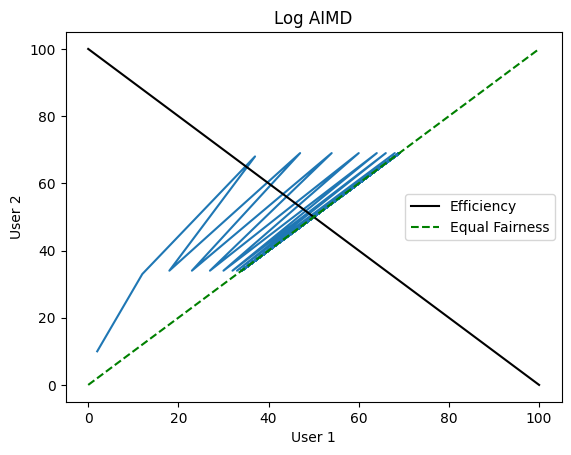

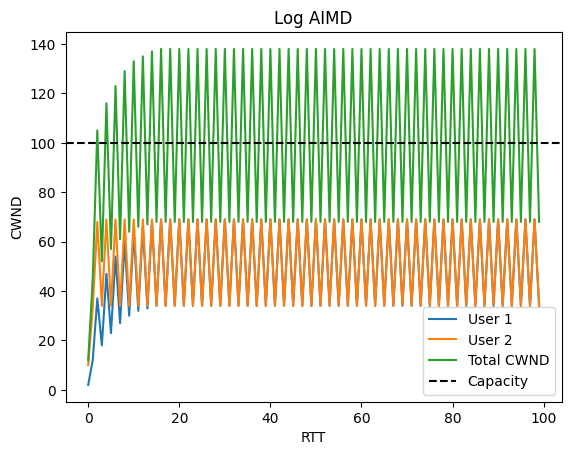

In [480]:
# Log
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [0.1*C, 0.1*C]

betas = [0.5, 0.5]

init_cwnds = [2, 10]

ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(LogAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i]))

name = "Log AIMD"
run_simulation(ITERATESMAX, C, users, name)

Behaves similarly to that of normal AIMD

******************** Log AIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 4
U1: 15, U2: 90
Multiplicative D at 7
U1: 11, U2: 112
Multiplicative D at 9
U1: 5, U2: 104
Multiplicative D at 12
U1: 4, U2: 124
Multiplicative D at 14
U1: 2, U2: 112
Multiplicative D at 16
U1: 0, U2: 104
Multiplicative D at 19
U1: 0, U2: 124
Multiplicative D at 21
U1: 0, U2: 112
Multiplicative D at 23
U1: 0, U2: 104
Multiplicative D at 26
U1: 0, U2: 124
Multiplicative D at 28
U1: 0, U2: 112
Multiplicative D at 30
U1: 0, U2: 104
Multiplicative D at 33
U1: 0, U2: 124
Multiplicative D at 35
U1: 0, U2: 112
Multiplicative D at 37
U1: 0, U2: 104
Multiplicative D at 40
U1: 0, U2: 124
Multiplicative D at 42
U1: 0, U2: 112
Multiplicative D at 44
U1: 0, U2: 104
Multiplicative D at 47
U1: 0, U2: 124
Multiplicative D at 49
U1: 0, U2: 112
Multiplicative D at 51
U1: 0, U2: 104
Multiplicative D at 54
U1: 0, U2: 124
Multiplicative D at 56
U1: 0, U2: 112
Multiplicative D at 58
U1: 0, 

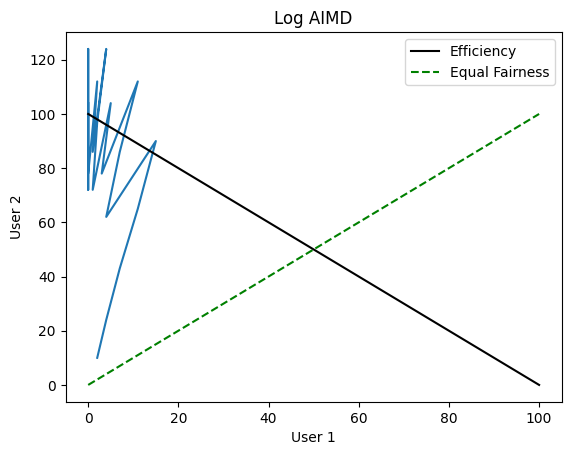

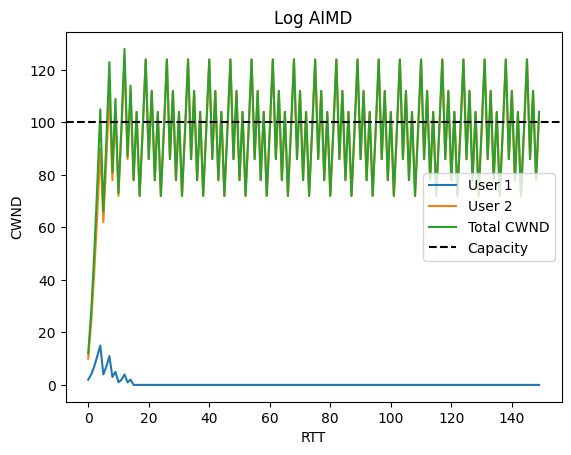

In [481]:
# Log
ITERATESMAX = 150 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [2, 6]

betas = [0.3, 0.7]

init_cwnds = [2, 10]

ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(LogAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i]))

name = "Log AIMD"
run_simulation(ITERATESMAX, C, users, name)

******************** Exponential+Log AIMD ********************
Initial User-1 CWND: 2
Initial User-2 CWND: 10
Multiplicative D at 12
U1: 495, U2: 89
Multiplicative D at 16
U1: 530, U2: 66
Multiplicative D at 20
U1: 561, U2: 54
Multiplicative D at 23
U1: 467, U2: 40
Multiplicative D at 27
U1: 507, U2: 38
Multiplicative D at 31
U1: 542, U2: 36
Multiplicative D at 35
U1: 572, U2: 35
Multiplicative D at 38
U1: 475, U2: 28
Multiplicative D at 42
U1: 514, U2: 30
Multiplicative D at 46
U1: 547, U2: 32
Multiplicative D at 50
U1: 575, U2: 33
Multiplicative D at 53
U1: 477, U2: 27
Multiplicative D at 57
U1: 515, U2: 29
Multiplicative D at 61
U1: 547, U2: 30
Multiplicative D at 65
U1: 575, U2: 32
Multiplicative D at 68
U1: 477, U2: 27
Multiplicative D at 72
U1: 515, U2: 29
Multiplicative D at 76
U1: 547, U2: 30
Multiplicative D at 80
U1: 575, U2: 32
Multiplicative D at 83
U1: 477, U2: 27
Multiplicative D at 87
U1: 515, U2: 29
Multiplicative D at 91
U1: 547, U2: 30
Multiplicative D at 95
U1: 575, 

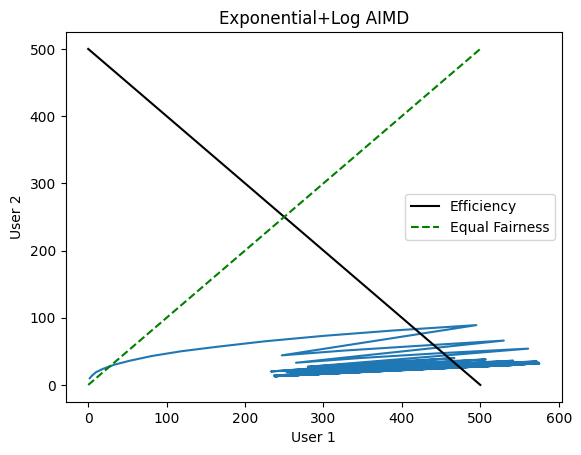

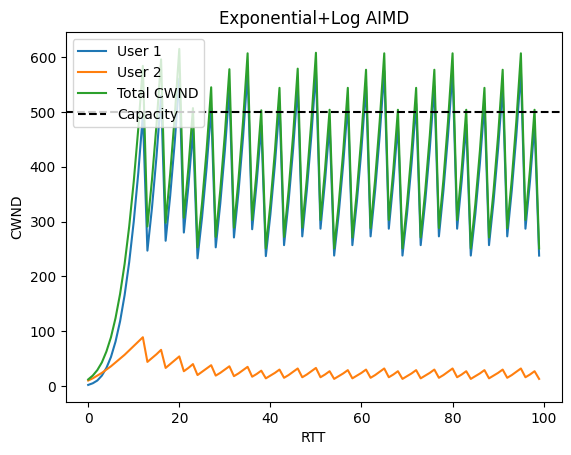

In [482]:
# Exponential+Log
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 500

# params
ALPHA = 1
BETA = 0.5


# Exponent users
ex_alphas = [2]

ex_betas = [0.5]

ex_init_cwnds = [2]

ex_ssthresholds = [float('inf')]

exponents = [2/3]

# Log users
log_alphas = [2]

log_betas = [0.5]

log_init_cwnds = [10]

log_ssthresholds = [float('inf')]

# Users
num_ex_users = len(exponents)
num_log_users = len(log_alphas)

users = []

for i in range(num_ex_users):
    users.append(ExponentialAIMD(ex_alphas[i], ex_betas[i], ex_init_cwnds[i], ex_ssthresholds[i], exponents[i]))
for i in range(num_log_users):
    users.append(LogAIMD(log_alphas[i], log_betas[i], log_init_cwnds[i], log_ssthresholds[i]))

name = "Exponential+Log AIMD"
run_simulation(ITERATESMAX, C, users, name)